# EEG preprocessing 

In this notebook: 
- Necessary imports
- Data loader for events, eeg and meta data
- Filtering algorithm
- EEG raw to epochs
- Epochs to evoked responses (ERPs)
- Averaging code for ERPS

Not working:
- Filtering algorithm
- ERPs based on channel

Missing:
- Grand average 
- Mismatch response
- Turning data into pandas dataframe

Preprocessing steps: 
+ Prepare EEG (1. Subtract reference (mastoids), 2. Detrend, 3. Filter, 4. Remove bad channels)
+ Segment EEG into standard and deviant epochs (ERPs) (1. subtract baseline, 2. Reject artefacts, 3. Average (for each marker/subject/channel separately))
+ Calculate Mismatch response (deviant - standard for a single subject) (check differences between channels and subjects)

## Imports

The data will be processed using the mne library. Also there are libraries made in eegyolk in order to load the metadata, eeg data and the event markers. Those libraries need to be imported

In [1]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from math import nan

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
from eegyolk import helper_functions as hf # library useful for eeg and erp data cleaning
from eegyolk import initialization_functions #library to import data
from eegyolk import epod_helper

## Load metadata and eeg files

First the different pathways for the different datasets need to be defined. There are three pathways: eeg, metadata and events. The files can be loaded using the initialization_functions library. All event markers needs to be saved in a seperate folder. If not saved already, the event markers will be saved using the initialization_function library. The data must be saved in a separate folder called "epod_data_not_pushed" in the ePodium repository. 

In [2]:
data_path = "/home/nprins/researchdrive/ePodium (Projectfolder)/"
path_dataset = os.path.join(data_path, "Dataset")
path_metadata = os.path.join(data_path, "Metadata")
path_events = os.path.join(data_path, "events")

In [5]:
# # load data
# path_metadata = os.path.join('../epod_data_not_pushed','metadata')
# path_eeg = os.path.join('../epod_data_not_pushed','not_zip')
# path_eventmarkers = os.path.join('../epod_data_not_pushed','not_zip', 'event_markers')

In [6]:
# load metadata
files_metadata = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
children, cdi, parents, codes = initialization_functions.load_metadata(path_metadata, files_metadata)

In [7]:
# load eeg

eeg, eeg_filename =  initialization_functions.load_dataset(path_eeg, preload=False) # preload must be set to True once on the cloud

99 EEG files loaded


In [8]:
# load events 
events_files = os.listdir(path_eventmarkers)
if len(events_files) == 0 or path_eventmarkers == False: # check if event markers are saved in a seperate folder
    initialization_functions.save_event_markers(path_eventmarkers, eeg, eeg_filename) # save event markers

event_markers = initialization_functions.load_events(path_eventmarkers, eeg_filename) # load event markers
event_markers_simplified = epod_helper.group_events_12(event_markers) # simplify events

99 Event Marker files loaded


## Data info

Choose which participant you want to view in the box below. 

In [9]:
index = widgets.IntText(
    step=0.1,
    description='Participant',
    disabled=False
)
widgets.VBox([index])

In [10]:
index = int(index.value)

In [11]:
eeg[index].plot(duration=0.1)

Using qt as 2D backend.
Opening raw-browser...


C:\Users\makeda\AppData\Local\Temp\ipykernel_10464\29831197.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(event_markers_simplified[index], event_id = epod_helper.event_dictionary)


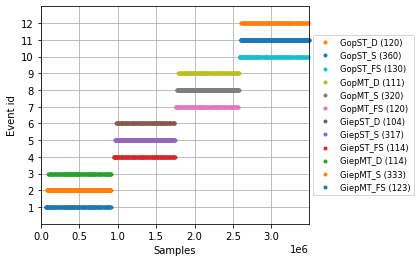

In [12]:
%matplotlib inline 
fig = mne.viz.plot_events(event_markers_simplified[index], event_id = epod_helper.event_dictionary)

## Filtering

Below you can define the frequencies for the bandpass filter. The lowpass can not be below 0 and the highpass can not be higher then 100

In [ ]:
lowpass = widgets.BoundedIntText(
    min=0,
    max=100,
    step=0.1,
    description='lowpass:',
    disabled=False
)

highpass = widgets.BoundedIntText(
    min=0,
    max=100,
    step=0.1,
    description='highpass:',
    disabled=False
)

widgets.VBox([lowpass,highpass])


In [ ]:
# change type to integer
lowpass = int(lowpass.value)
highpass = int(highpass.value)

In [ ]:
# bandpass, notch and bad channel filter
# freqs = (60, 120, 180, 240)
# 
# def filter_eeg(eeg, lowpass, highpass, freqs):
#     for i in range(len(eeg)): eeg[i] = hf.band_pass_filter(eeg[i], lowpass, highpass) # bandpass filter
#     for i in range(len(eeg)): # remove bad channels
#         if len(eeg[i].info['bads']) != 0:
#             eeg[i] = mne.pick_types(eeg[i].info, meg=False, eeg=True, exclude='bads')
#     for i in range(len(eeg)): eeg[i] = mne.notch_filter(eeg[i], freqs=freqs) # notch filter
#     return eeg
# 
# eeg = filter_eeg(eeg, lowpass, highpass, freqs)

Bandpass filter doesn't work due to memory issues. Can be fixed with preload = True in the load_data() in helper_functions.py. However, jupyter crashes due to lack of memory when done. Needs to be fixed. The data contains power line noise which disrupts the rest of the signal. The notch filter filters out the fequency of 50 Hz. Does not work because of the preload memory issue. 

In [ ]:
for i in range(len(eeg)): eeg[i] = hf.filter_eeg_raw(eeg[i], lowpass, highpass, 'freqs')

In [ ]:
# plot of the used sensors
for i in range(len(eeg)): 
    montage = mne.channels.make_standard_montage('standard_1020')
    #montage.plot(kind='topomap', show_names=True)
    eeg[index].info.set_montage(montage, on_missing='ignore')


In [ ]:
eeg[index].plot_sensors(ch_type='eeg', show_names=True)

In [ ]:
drop_ch = ['EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8']
eeg[index].drop_channels(drop_ch)

## Creating epoched data

Epochs are created with joining the eeg data with a specific event. tmin and tmax are the start and stop time relative to each event. mne.Epochs automaticaly create a baseline correction.

In [13]:
event_dictionary = epod_helper.event_dictionary
event_dictionary

{'GiepMT_FS': 1,
 'GiepMT_S': 2,
 'GiepMT_D': 3,
 'GiepST_FS': 4,
 'GiepST_S': 5,
 'GiepST_D': 6,
 'GopMT_FS': 7,
 'GopMT_S': 8,
 'GopMT_D': 9,
 'GopST_FS': 10,
 'GopST_S': 11,
 'GopST_D': 12}

For a selected event, an interval is created with a time before and after event. This represents an epoch. 

In [14]:
epochs = hf.create_epochs(eeg, event_markers_simplified, -0.3, 0.7)

Not setting metadata
2266 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2389 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2208 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2521 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mod

Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2471 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [16]:
print(len(epochs))

99


Evoked responses are created by averaging the data for a specific event

In [ ]:
evoked = hf.evoked_responses(epochs, event_dictionary)

In [ ]:
for i in range(len(event_dictionary)):
    evoked[index][i].plot(spatial_colors=True, exclude='bads')
    print(([key for key in epod_helper.event_dictionary.keys()][i], [value for value in epod_helper.event_dictionary.values()][i]))

In [ ]:
channelnames = epochs[1].ch_names

In [ ]:
evoked[index][1].plot_joint()

In [ ]:
c1 = mne.grand_average(evoked[index])
c1.plot(spatial_colors=True)

In [ ]:
std_evoked = epochs[index][2,5,8,11].average()
dev_evoked = epochs[index][3,6,9,12].average()

In [ ]:
#difference=std_evoked-dev_evoked
std_evoked.plot()

In [ ]:
evokeds = dict(standard=std_evoked, deviant=dev_evoked)
mne.viz.plot_compare_evokeds(evokeds, combine='mean')


## Create pandas dataset out of epoched data

In [ ]:
epochs = epochs[0:4] # subset to test function
def create_pd_df(epochs):
    df_epochs = pd.DataFrame()

    for i in range(len(epochs)):
        df = epochs[i].to_data_frame()
        df['index'] = i
        df_epochs = df_epochs.append(df)
    return df_epochs

create_pd_df(epochs)

In [ ]:
df_epochs